# 주가 정보 스크래핑 후 예측
## 삼성전자 주가 정보 스크래핑
* 일별시세
    - 날짜
    - 종가
    - 전일비
    - 시가
    - 고가
    - 저가
    - 거래량

In [77]:
import csv
import requests
from bs4 import BeautifulSoup
from selenium import webdriver

headers = {"User-Agent":"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"}
url = "https://finance.naver.com/item/sise.naver?code=005930"

daily_stock_infos = list()

filename = "samsung_stock_info.csv"
f = open(filename, "w", encoding="utf-8-sig", newline = "")
writer = csv.writer(f)
writer.writerow(["날짜", "종가", "전일비", "시가", "고가", "저가", "거래량"])

res = requests.get(url)
soup = BeautifulSoup(res.content, "html.parser")
daily_values_url = soup.find("iframe", attrs={"title":"일별 시세"})["src"]

for page in range(1, 20):
    r = requests.get(f"https://finance.naver.com{daily_values_url}&page={page}", headers=headers)
    soup = BeautifulSoup(r.content, "html.parser")
    daily_values = soup.select('table.type2 tr')
    
    for d in daily_values:
        infos = d.select("td")
        if len(infos) <= 1:
            continue
        else:
            daily_stock_infos.append(list(info.select_one('span').text.strip() for info in infos))

for dsi in daily_stock_infos:
    writer.writerow(dsi)

f.close()

# LSTM을 활용한 주가 예측 모델
* FinanceDataReader를 활용하여 주가 데이터를 받아옴

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
import FinanceDataReader as fdr

STOCK_CODE = '005930'

stock = fdr.DataReader(STOCK_CODE)

In [9]:
type(stock)

pandas.core.frame.DataFrame

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


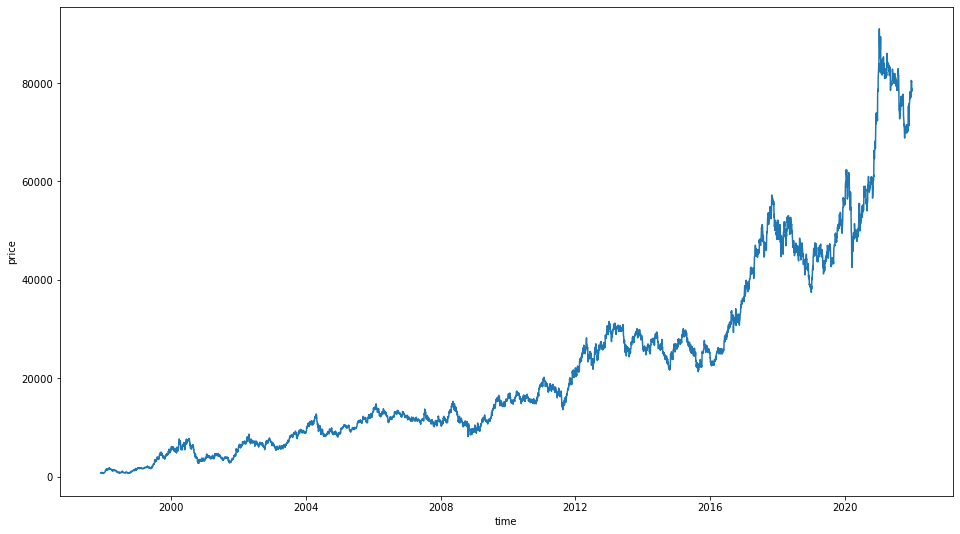

In [3]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

## 데이터 전처리

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.00863787, 0.00821281, 0.00855866, 0.0015602 , 0.0024459 ],
       [0.00850498, 0.0080062 , 0.00807821, 0.00134996, 0.00232547],
       [0.00810631, 0.00786157, 0.00802235, 0.00142742, 0.00148572],
       ...,
       [0.87375415, 0.82128099, 0.8726257 , 0.8594713 , 0.15764924],
       [0.87929125, 0.82438017, 0.87374302, 0.86279088, 0.14951482],
       [0.87264673, 0.81818182, 0.87486034, 0.8638974 , 0.13728749]])

In [5]:
# 스케일이 완료된 column으로 새로운 데이터프레임 생성
df = pd.DataFrame(scaled, columns=scale_cols)

In [8]:
# train/test 분할
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)
x_train.shape, y_train.shape
x_test.shape, y_test.shape

((1200, 4), (1200,))

## TensorFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [9]:
import tensorflow as tf

In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
WINDOW_SIZE=20
BATCH_SIZE=32

# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

Metal device set to: Apple M1


2022-01-04 23:31:18.146270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-04 23:31:18.147003: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


2022-01-04 23:31:21.062600: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [14]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [17]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춤
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [18]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50


2022-01-04 23:32:17.929338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 23:32:18.197328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 23:32:19.328086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


    150/Unknown - 5s 12ms/step - loss: 3.4287e-04 - mse: 6.8575e-04

2022-01-04 23:32:22.596764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 23:32:22.651460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.00044, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 5s 16ms/step - loss: 3.4287e-04 - mse: 6.8575e-04 - val_loss: 4.3522e-04 - val_mse: 8.7045e-04
Epoch 2/50
147/150 [============================>.] - ETA: 0s - loss: 2.2391e-05 - mse: 4.4781e-05
Epoch 00002: val_loss did not improve from 0.00044
150/150 [==============================] - 2s 13ms/step - loss: 2.2683e-05 - mse: 4.5365e-05 - val_loss: 4.4745e-04 - val_mse: 8.9490e-04
Epoch 3/50
146/150 [============================>.] - ETA: 0s - loss: 2.2210e-05 - mse: 4.4419e-05
Epoch 00003: val_loss improved from 0.00044 to 0.00042, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 2s 13ms/step - loss: 2.2638e-05 - mse: 4.5275e-05 - val_loss: 4.1763e-04 - val_mse: 8.3526e-04
Epoch 4/50
150/150 [==============================] - ETA: 0s - loss: 2.1825e-05 - mse: 4.3651e-05
Epoch 00004: val_loss did not improve from 0.00042
15

Epoch 28/50
149/150 [============================>.] - ETA: 0s - loss: 1.7941e-05 - mse: 3.5882e-05
Epoch 00028: val_loss did not improve from 0.00019
150/150 [==============================] - 2s 13ms/step - loss: 1.7975e-05 - mse: 3.5951e-05 - val_loss: 6.4417e-04 - val_mse: 0.0013
Epoch 29/50
149/150 [============================>.] - ETA: 0s - loss: 1.7954e-05 - mse: 3.5908e-05
Epoch 00029: val_loss did not improve from 0.00019
150/150 [==============================] - 2s 13ms/step - loss: 1.7926e-05 - mse: 3.5852e-05 - val_loss: 4.1533e-04 - val_mse: 8.3066e-04
Epoch 30/50
148/150 [============================>.] - ETA: 0s - loss: 1.7065e-05 - mse: 3.4129e-05
Epoch 00030: val_loss did not improve from 0.00019
150/150 [==============================] - 2s 13ms/step - loss: 1.7184e-05 - mse: 3.4368e-05 - val_loss: 3.3755e-04 - val_mse: 6.7510e-04


In [19]:
model.load_weights(filename)

In [20]:
pred = model.predict(test_data)

2022-01-04 23:33:26.119451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 23:33:26.163065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [21]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

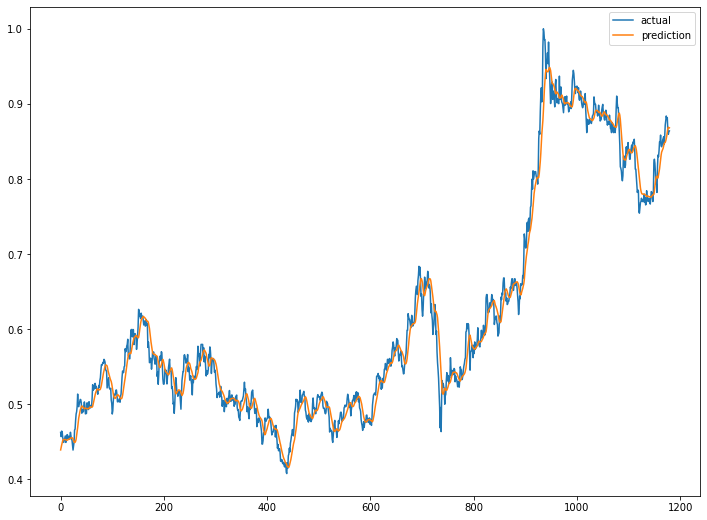

In [22]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()